#### Extension Of EM Algorithm

In [16]:
import csv, copy, gzip, pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2, norm

In [17]:
#Loading the data
with open('data/faithful.txt', 'rt') as f:
    dataReader = csv.reader(f, delimiter=' ')
    # initialize an empty array
    data = []
    for row in dataReader:
        data.append(np.array(row).astype(np.float))
    # convert data into a numpy array
    data = np.asarray(data)

In [18]:
#Number of Gaussian Mixture Model
ngmm = 2

In [19]:
#Mean
mu = np.array([[2, 70], [4, 80]], dtype='float')

In [20]:
#Covariance
sigma = np.array([[[1, 0], [0, 3]], [[0.5, 0.2], [0.2, 0.6]]], dtype='float')

In [21]:
#This function checks if the covariance matrix is legal
def covmatIsLegal(sigma):
    #print(sigma.shape)
    #print(sigma)
    for covmat in sigma:
        if not(np.allclose(covmat, covmat.T)) or np.any(np.linalg.eigvals(covmat) <= 0):
            return False
    return True

print(covmatIsLegal(sigma))

True


In [22]:
gmm = [{'mean':mu[m], 'covariance':sigma[m], "prior":0.5} for m in range(ngmm)]

In [61]:
#These functions plot the Gaussian Mixture Model

def plotGaussianModel2D(mu, sigma, pltopt='k'):
    if sigma.any():
        # calculate ellipse constants
        c = chi2.ppf(0.9, 2) # use confidence interval 0.9
        # get eigen vector and eigen values
        eigenValue, eigenVector = np.linalg.eig(sigma)
        # calculate points on ellipse
        t = np.linspace(0, 2*np.pi, 100) # draw 100 points
        u = [np.cos(t), np.sin(t)]
        w = c * eigenVector.dot(np.diag(np.sqrt(eigenValue)).dot(u))
        z = w.T + mu
        print(w.shape)
        print(mu.shape)
    else:
        z = mu
    # plot ellipse by connecting sample points on curve
    plt.plot(z[:,0], z[:,1], pltopt)
    
    
def colorPicker(index):
    colors = 'rgbcmyk'
    return colors[np.remainder(index, len(colors))]

def gmmplot(data, gmm):
    # plot data points
    plt.scatter(data[:, 0], data[:, 1], s=4)
    # plot Gaussian model
    color = 'rgb'
    for index, model in enumerate(gmm):
        plotGaussianModel2D(model['mean'], model['covariance'], colorPicker(index))
    #plt.show()

(2, 100)
(2,)
(2, 100)
(2,)


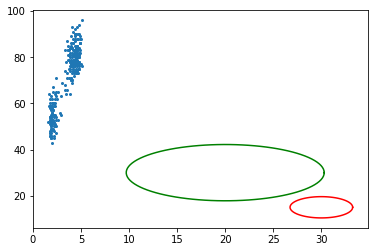

In [62]:
gmmplot(data, gmm)
plt.show()

In [25]:
#probability that a point came from a Gaussian with given parameters
def probability(points, parameters_dict):
    prior = parameters_dict['prior']
    mu = parameters_dict['mean']
    sigma = parameters_dict['covariance']
    #print(sigma)
    prob = prior
    for i in range(0, len(points)):
        prob *= norm.pdf(points[i], mu[i], sigma[i][i])
    return prob

In [26]:
def expectation(data, parameters):
    posterior = []
    for i in range(0, data.shape[0]):
        x = data[i][0]
        y = data[i][1]
        clusters_prob_value = []
        for j in range(0, len(parameters)):
            clusters_prob_value.append(probability([x, y], parameters[j]))
        #print(clusters_prob_value)
        clusters_prob_values = np.array(clusters_prob_value)
        #print(clusters_prob_values.argmax())
        posterior.append(clusters_prob_values.argmax())
    return posterior

In [ ]:
#For this Excerise I am not changing the covariance matrix. 
def maximization(posterior, data, parameters):
    data = pd.DataFrame(data=data)
    data['c'] = posterior
    cluster_1_points = data[data['c'] == 1]
    #print(len(cluster_1_points[0]))
    cluster_2_points = data[data['c'] == 2]
    cluster_1_count = len(cluster_1_points)
    cluster_2_count = len(cluster_2_points)
    total = cluster_1_count + cluster_2_count
    
    if len(cluster_1_points) == 0:
        mu1 = parameters[0]['mean']
        sigma1 = parameters[0]['covariance']
    else:
        mu1 = [abs(cluster_1_points[0].mean()), abs(cluster_1_points[1].mean())]
        sigma1 = [[abs(cluster_1_points[0].std()), 0], [0, abs(cluster_1_points[1].std())]]
    if len(cluster_2_points) == 0:
        mu2 = parameters[1]['mean']
        sigma2 = parameters[1]['covariance']
    else:
        mu2 = [abs(cluster_2_points[0].mean()), abs(cluster_2_points[1].mean())]
        sigma2 = [[abs(cluster_2_points[0].std()),0], [0, abs(cluster_2_points[1].std())]]
    #print(total)
    prior_1 = cluster_1_count / float(total)
    prior_2 = cluster_2_count / float(total)
    sigma1 = np.array(sigma1)
    #print(sigma1.shape)
    sigma2 = np.array(sigma2)
    #if not covmatIsLegal(np.array([sigma1,sigma2])):
        #print('True')
        #sigma1 = parameters[0]['covariance']
        #sigma2 = parameters[1]['covariance']
    #if not covmatIsLegal(sigma2):
    dict_1 = {'mean': mu1, 'covariance': sigma1, 'prior': prior_1}
    dict_2 = {'mean': mu2, 'covariance': sigma2, 'prior': prior_2}
    parameters = [dict_1, dict_2]
    return parameters

In [48]:
def maximization_mean(posterior, data, parameters):
    data = pd.DataFrame(data=data)
    data['c'] = posterior
    new_parameters = parameters
    for i in range(0, len(parameters)):
        points = data[data['c'] == i]
        count_points = len(points)
        if count_points == 0:
            continue
        prior = count_points / len(data)
        mu = []
        sigma = []
        for j in range(0, data.shape[1]-1):
            mu.append(points[j].mean())
            mod_sigma = np.zeros((data.shape[1]-1))
            mod_sigma[j] = points[j].std()
            sigma.append(mod_sigma)
        sigma = np.array(sigma)
        vals_dict = {'mean':mu, 'covariance': sigma, 'prior':prior}
        parameters[i] = vals_dict
    return new_parameters

In [28]:
gmmcp = gmm.copy()
posterior = expectation(data, gmmcp)
print(posterior)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]


In [29]:
parameters = maximization_mean(posterior, data, gmmcp)
print(parameters)

[{'mean': [3.198149253731343, 67.50248756218906], 'covariance': array([[  1.18227881,   0.        ],
       [  0.        ,  14.31507051]]), 'prior': 0.7389705882352942}, {'mean': [4.307732394366198, 80.507042253521121], 'covariance': array([[ 0.35630653,  0.        ],
       [ 0.        ,  1.81165465]]), 'prior': 0.2610294117647059}]


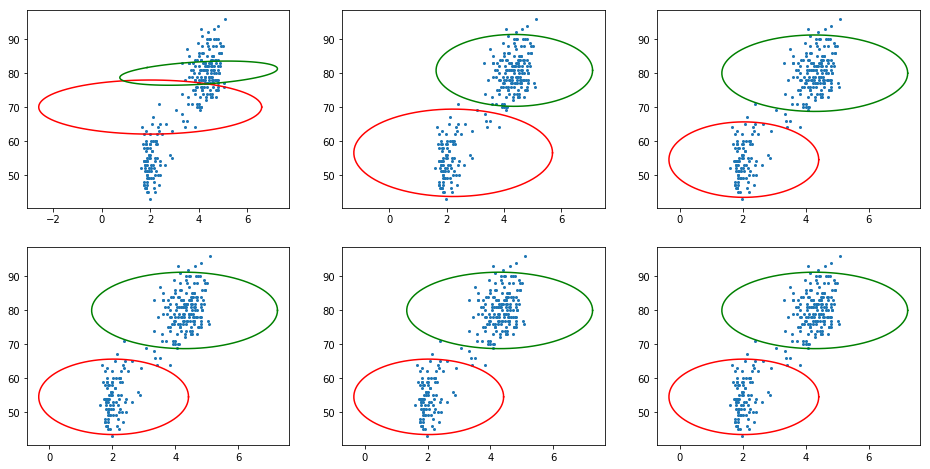

In [30]:
# make a true copy of our model
gmmcp = gmm.copy()
#print(data)
#print(data)
#print(gmmcp)
# create figure
plt.figure(figsize=(16, 8))
# improve model with EM-Algorithm
for i in range(5):
    # plot current status
    plt.subplot(231 + i)
    #print(gmmcp)
    gmmplot(data, gmmcp)
    # excute EM-Algorithm
    for j in range(5):
        posterior = expectation(data, gmmcp)
        gmmcp = maximization_mean(posterior, data, gmmcp)
        #print('here')
        #print(gmmcp)
# plot final status
plt.subplot(236)
#print(data)
gmmplot(data,gmmcp)
plt.show()

As you can see, from the previous exercise the ellipses have fitted better when covariance and priors are optimized during the maximization step.

In [49]:
x1, y1 = np.random.multivariate_normal([30, 50],[[0.5, 0],[0, 1]], 100).T
x2, y2 = np.random.multivariate_normal([40, 50],[[0.5, 0],[0, 0.7]], 100).T
new_data = []
for i in range(0, 100):
    each_point = [x1[i], y1[i]]
    new_data.append(each_point)
for i in range(0, 100):
    each_point = [x2[i], y1[i]]
    new_data.append(each_point)    
print(np.array(new_data).shape) 
new_data = np.array(new_data)

(200, 2)


In [50]:
#Mean
mu = np.array([[30, 15], [20, 30]], dtype='float')

In [51]:
#Covariance
sigma = np.array([[[0.5, 0], [0, 1]], [[5, 0], [0, 7]]], dtype='float')

In [52]:
print(covmatIsLegal(sigma))

True


In [53]:
gmm = [{'mean':mu[m], 'covariance':sigma[m], "prior":0.5} for m in range(ngmm)]

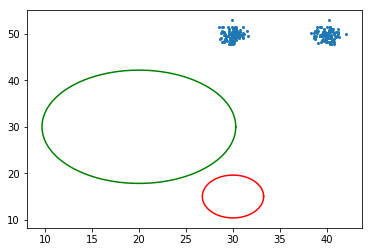

In [55]:
gmmplot(new_data, gmm)
plt.show()

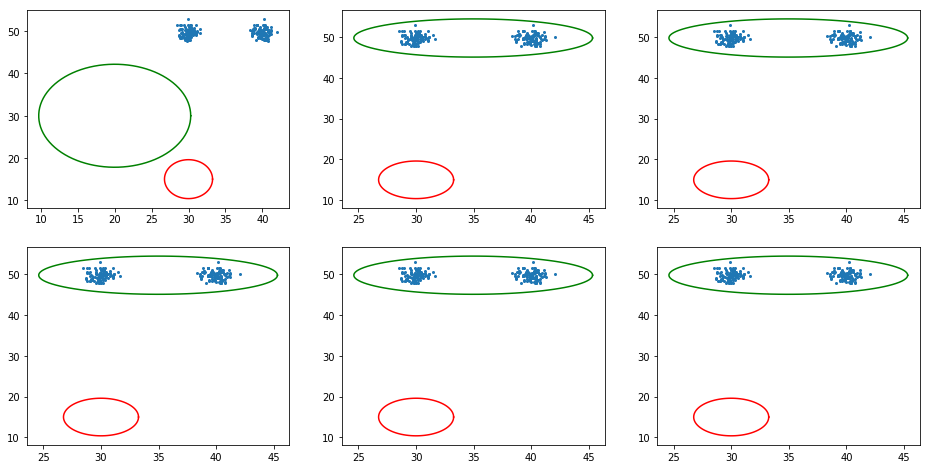

In [57]:
# make a true copy of our model
gmmcp = gmm.copy()
#print(data)
#print(gmmcp)
# create figure
plt.figure(figsize=(16, 8))
# improve model with EM-Algorithm
for i in range(5):
    # plot current status
    plt.subplot(231 + i)
    gmmplot(new_data, gmmcp)
    # excute EM-Algorithm
    for j in range(5):
        posterior = expectation(new_data, gmmcp)
        #print(posterior)
        gmmcp = maximization_mean(posterior, new_data, gmmcp)
        #print(gmmcp)
# plot final status
plt.subplot(236)
gmmplot(new_data,gmmcp)
plt.show()

The above result is due to the fact that all the values are being clustered into the 2nd cluster and none of them are being added in the 1st cluster.

Here I have also used the scikit-learn's inbuilt method for Gaussian Mixture Models and performed clustering. Taken from the sklearn tutorials.

In [8]:
from sklearn import mixture
import matplotlib as mpl
import itertools
from scipy import linalg

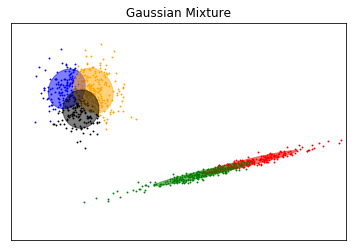

In [15]:
color_iter = itertools.cycle(['blue', 'red', 'green', 'orange', 'black'])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(1,1, 1+index)
    for i , (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)
        
        #Plotting the ellipse to show Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
        
    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    
#Number of samples per component
n_samples = 500

#Generating random samples'np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C), .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

#Fitting a Gaussian Mixture with EM using 5 components
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, 'Gaussian Mixture')
plt.show()